# Weather data

In [3]:
%cd ..

c:\Users\maher\RLNAS-for-Anomaly-Detection-in-Time-Series-using-Autoencoders


In [2]:
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

random.seed(19)

In [4]:
data_path = "dataset/weather_data/IHAMPS1.csv"
dataset = pd.read_csv(data_path)
dataset_name = data_path.split('/')[-1].split('.')[0]

dataset.columns

Index(['Date', 'Time', 'Temperature_C', 'Dew_Point_C', 'Humidity_%', 'Wind',
       'Speed_kmh', 'Gust_kmh', 'Pressure_hPa', 'Precip_Rate_mm',
       'Precip_Accum_mm', 'UV', 'Solar_w/m2'],
      dtype='object')

In [5]:
feature_name = "Humidity_%"
feat = dataset[feature_name]
feat = feat.dropna()
feat = feat.values

11338 11438


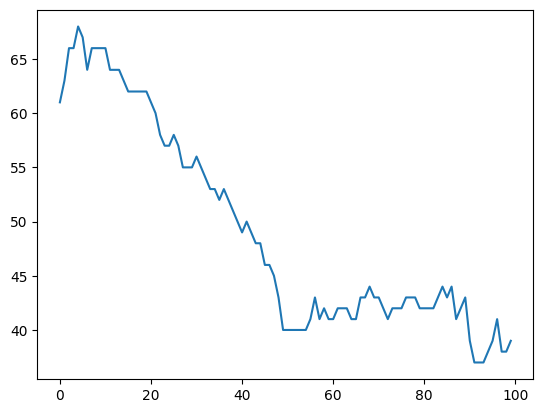

136437 136537


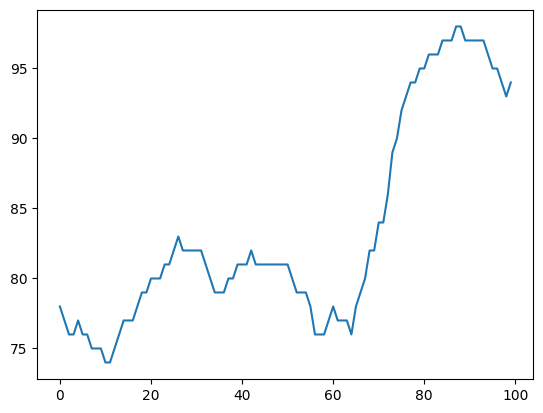

31637 31737


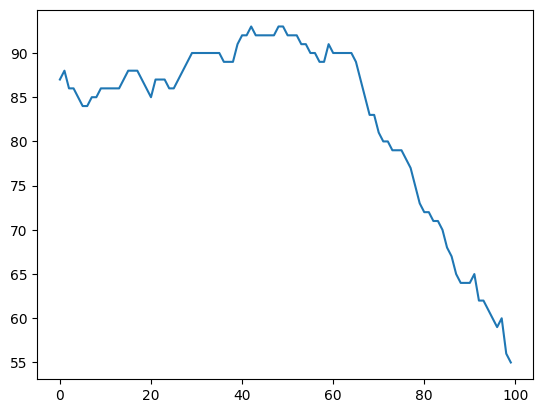

In [6]:
window_size = 100

start = 0
end = window_size

for i in range(3):
    start = random.randint(0, len(feat)-window_size)
    end = start + window_size
    print(start, end)
    plt.plot(feat[start:end])
    plt.show()


Run `gen_anomalies.ipynb` to generate anomalies for the dataset

In [7]:
loc_anom_path = f"dataset/gen_anomalies/locOuts_{dataset_name}.csv"
loc_anom_df = pd.read_csv(loc_anom_path)
loc_anom_df = loc_anom_df.dropna()
loc_anom_feat = loc_anom_df[feature_name]

glob_anom_path = f"dataset/gen_anomalies/gloOuts_{dataset_name}.csv"
glob_anom_df = pd.read_csv(glob_anom_path)
glob_anom_df = glob_anom_df.dropna()
glob_anom_feat = glob_anom_df[feature_name]

In [8]:
pd.DataFrame(feat).describe()

,0
count,138997.000000
mean,75.860573
std,16.666075
min,16.000000
25%,66.000000
50%,78.000000
75%,89.000000
max,99.000000


In [9]:
anom_feat = pd.concat([loc_anom_feat, glob_anom_feat], axis=0)
anom_feat.describe()

count    30000.000000
mean        69.936812
std         31.194103
min        -46.777477
25%         45.422805
50%         72.780616
75%         95.042773
max        174.967706
Name: Humidity_%, dtype: float64

### Injecting anomalies

In [10]:
window_size = 100
step = 50

lb = 0
hb = window_size
train_size = len(feat)/window_size*window_size/step*0.8

train_out = []
train_gt = []
test_out = []
test_gt = []

i = 0
while hb<len(feat):
    normal_sample = feat[lb:hb]
    
    # train data
    if i<train_size:
        train_out.append(normal_sample)
        train_gt.append(0)

    # contaminated test data
    else:
        normal_sample = feat[lb:hb]
        r = random.random()
        if r<0.2:
            ts = normal_sample.copy()
            anom_t = random.randint(int(0.25*window_size), int(0.75*window_size))

            id = random.randint(0, len(anom_feat))
            ts[anom_t] = anom_feat.values[id]

            test_out.append(ts)
            test_gt.append(1)
            
        else:
            test_out.append(normal_sample)
            test_gt.append(0)

    lb += step 
    hb += step 
    i += 1

train_out_df = pd.DataFrame(train_out)
train_out_df["gt"] = train_gt
train_out_df.to_csv(f"dataset/synth_ts_data/train_{dataset_name}_{feature_name}.csv", index=False)

test_out_df = pd.DataFrame(test_out)
test_out_df["gt"] = test_gt
test_out_df.to_csv(f"dataset/synth_ts_data/test_{dataset_name}_{feature_name}.csv", index=False)

print(len(train_gt))
print(len(test_gt))
i


2224
554


2778

In [11]:
saved_path = f"dataset/synth_ts_data/test_{dataset_name}_{feature_name}.csv"
contam_data = pd.read_csv(saved_path)

34


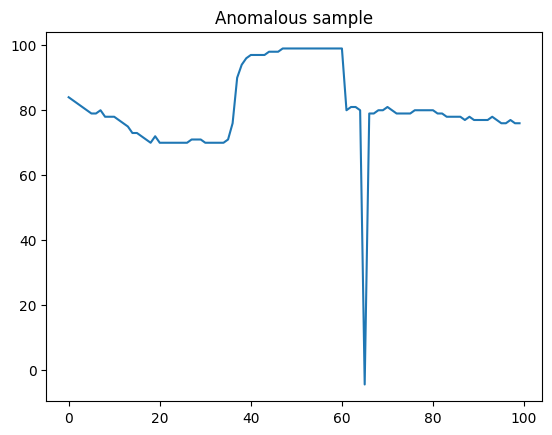

In [12]:
for i_sample in range(contam_data.shape[0]):
    gt = contam_data.iloc[i_sample][-1]
    
    if gt==1 and i_sample>21:
        print(i_sample+2)
        plt.plot(contam_data.iloc[i_sample][:-1].values)
        plt.title("Anomalous sample")
        break
